In [27]:
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gmean, rankdata
# from scipy.stats import ttest_rel
import time

import lightgbm as lgb
import re


from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
train = pd.read_csv("data_input/train.csv")
print("data.shape = {} rows, {} cols".format(*train.shape))
# train.head(n=2)

data.shape = 110093 rows, 3 cols


In [3]:
# Тестовые данные
test = pd.read_csv("data_input/test.csv")
print("data.shape = {} rows, {} cols".format(*test.shape))
# test.head(n=2)

data.shape = 165141 rows, 2 cols


In [4]:
client_profile = pd.read_csv("data_input/client_profile.csv")
print("data.shape = {} rows, {} cols".format(*client_profile.shape))
# client_profile.head(n=2)

data.shape = 250000 rows, 24 cols


In [5]:
# Объеденим датафреймы
train = train.merge(client_profile, on=['APPLICATION_NUMBER'], how='left')
test = test.merge(client_profile, on=['APPLICATION_NUMBER'], how='left')

In [6]:
# Приведем все имена колонок к нижнему рег
train.columns = [col.lower() for col in train.columns]
test.columns = [col.lower() for col in test.columns]

In [7]:
# Создадим пустой датафрейм предсказаний
submission = pd.DataFrame(test['application_number'])

1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [8]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [9]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [10]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

In [11]:
# Создадим Kfold=7, разделим трейн на Тагрет и данные
cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, data = train["target"], train.drop(["application_number", "target"], axis=1)
test = test.drop(["application_number"], axis=1)

In [12]:
# Обработаем категориальные переменные
train1 = pd.concat([data, test], axis=0).reset_index(drop=True)
categorical = train1.select_dtypes(["object"]).columns
train1 = pd.get_dummies(train1, columns=categorical)

data_ohe = train1.loc[:data.shape[0]-1]
test_ohe = train1.loc[data.shape[0]:]

In [13]:
# Получим модели и ООФ прогнозы ка Kfold=7 для ЛайтДЖИБИЭМ
estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, data_ohe, target, cv
)

Wed Dec 16 11:40:37 2020, Cross-Validation, 110093 rows, 36 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.727938	valid_0's binary_logloss: 0.273071
[100]	valid_0's auc: 0.727204	valid_0's binary_logloss: 0.267905
[150]	valid_0's auc: 0.729069	valid_0's binary_logloss: 0.264204
[200]	valid_0's auc: 0.729258	valid_0's binary_logloss: 0.261317
[250]	valid_0's auc: 0.729607	valid_0's binary_logloss: 0.259201
[300]	valid_0's auc: 0.730724	valid_0's binary_logloss: 0.25753
[350]	valid_0's auc: 0.73091	valid_0's binary_logloss: 0.256294
[400]	valid_0's auc: 0.731161	valid_0's binary_logloss: 0.255335
[450]	valid_0's auc: 0.731509	valid_0's binary_logloss: 0.254587
[500]	valid_0's auc: 0.732082	valid_0's binary_logloss: 0.253988
[550]	valid_0's auc: 0.732433	valid_0's binary_logloss: 0.253479
[600]	valid_0's auc: 0.732868	valid_0's binary_logloss: 0.25305
[650]	valid_0's auc: 0.73348	valid_0's binary_logloss: 0.252707
[700]	valid_0's auc: 0.733595	va

In [14]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=7, random_state=42, shuffle=True)

In [15]:
# Получим модели и ООФ прогнозы ка Kfold=7 для ИКСДЖИБУСТ
estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(
    xgb_params, data_ohe, target, xgb_cv
)

Wed Dec 16 11:41:15 2020, Cross-Validation, 110093 rows, 36 cols
[11:41:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.66622	valid-auc:0.67349
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.71222	valid-auc:0.72233
[20]	train-auc:0.71464	valid-auc:0.72434
[30]	train-auc:0.71962	valid-auc:0.72915
[40]	train-auc:0.71968	valid-auc:0.72986
[50]	train-auc:0.72197	valid-auc:0.73041
[60]	train-auc:0.72370	valid-auc:0.73079
[70]	train-auc:0.72581	valid-auc:0.73220
[80]	train-auc:0.72755	valid-auc:0.73286
[90]	train-auc:0.72881	valid-auc:0.

[70]	train-auc:0.72966	valid-auc:0.70172
[80]	train-auc:0.73177	valid-auc:0.70429
[90]	train-auc:0.73281	valid-auc:0.70586
[100]	train-auc:0.73457	valid-auc:0.70679
[110]	train-auc:0.73564	valid-auc:0.70737
[120]	train-auc:0.73638	valid-auc:0.70873
[130]	train-auc:0.73772	valid-auc:0.70921
[140]	train-auc:0.73849	valid-auc:0.71017
[150]	train-auc:0.73929	valid-auc:0.71024
[160]	train-auc:0.73993	valid-auc:0.71018
[170]	train-auc:0.74016	valid-auc:0.71063
[180]	train-auc:0.74077	valid-auc:0.71095
[190]	train-auc:0.74144	valid-auc:0.71079
[200]	train-auc:0.74179	valid-auc:0.71065
Stopping. Best iteration:
[183]	train-auc:0.74086	valid-auc:0.71103

Fold 6, Valid score = 0.71063
[11:42:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thro

In [16]:
# ПУстой фрэйм для тестовых предсказаний на моделях ООФ
scores = pd.DataFrame()

In [17]:
# ПОлучи все предсказания на тесте от всех моделей
for i, _estimator in enumerate([estimators_lgbm, estimators_xgb]):
    for j, _model in enumerate(_estimator):
        if i == 1:
            scores[f'pred_{i}_{j}'] = _model.predict(xgb.DMatrix(test_ohe))
        else:
            scores[f'pred_{i}_{j}'] = _model.predict_proba(test_ohe)[:, 1]
        

<AxesSubplot:>

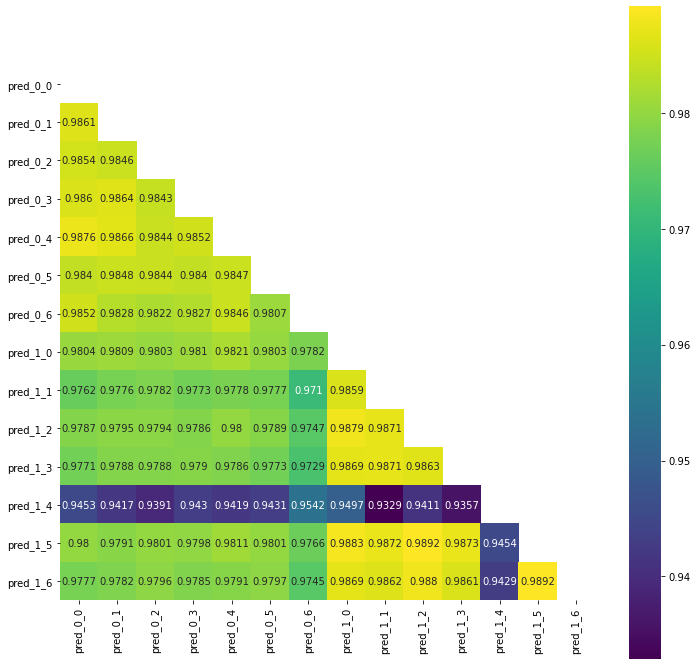

In [18]:
# Посмотрим корреялцию предсказаний между собой
corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Выводы:Модели Lgm и XGB имеют в большинстве меньше 0,98. Внутри одной модеил есть корреляции ниже 0,95. Это значит, что такие прогнозы подойдут ансамблрования предсказания

2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [19]:
# арифмитическое среднее
submission['sumbit_mean'] = scores.mean(axis=1)

In [20]:
# геометрического среднего
submission['sumbit_gmean'] = gmean(scores, axis=1)

In [21]:
# усреднить ранги арифмитическое 
submission['sumbit_rank_mean'] = scores.rank().mean(axis=1)

In [22]:
# усреднить ранги геометрическое 
submission['sumbit_rank_gmean'] = gmean(scores.rank(), axis=1)

In [23]:
# Сохраним данные для загрузки на Лидерборд
submission[['application_number', 'sumbit_mean']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_mean':'TARGET'}).\
            to_csv('out/sumbit_mean.csv', index = False)
submission[['application_number', 'sumbit_gmean']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_gmean':'TARGET'}).\
            to_csv('out/sumbit_gmean.csv', index = False)
submission[['application_number', 'sumbit_rank_mean']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_rank_mean':'TARGET'}).\
            to_csv('out/sumbit_rank_mean.csv', index = False)
submission[['application_number', 'sumbit_rank_gmean']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_rank_mean':'TARGET'}).\
            to_csv('out/sumbit_rank_gmean.csv', index = False)

Выводы: На лидерборде показатели такие:<br>
    арифмитическое среднее - 0.72225<br>
    геометрическое среднеее - 0.72231<br>
    усреднить ранги арифмитическое - <br>
    усреднить ранги геометрическое - <br>
    

3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [34]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=5000
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [29]:
cb_params = {
    "n_estimators": 7000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 10,
    "max_depth": 5,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

In [30]:
# Создадим Kfold=7 стратегию валидации
cat_cv = KFold(n_splits=7, random_state=32, shuffle=True)

In [35]:
# Получим ООФ прогнозы и модели для КатБуст
estimators_cat, oof_preds_cat = catboost_cross_validation(
    cb_params, data_ohe, target, cat_cv
)

Wed Dec 16 11:48:57 2020, Cross-Validation, 110093 rows, 36 cols
0:	test: 0.5729221	best: 0.5729221 (0)	total: 125ms	remaining: 14m 32s
50:	test: 0.6898904	best: 0.6905486 (35)	total: 906ms	remaining: 2m 3s
100:	test: 0.6966730	best: 0.6974768 (99)	total: 1.65s	remaining: 1m 52s
150:	test: 0.6988876	best: 0.6990071 (146)	total: 2.38s	remaining: 1m 47s
200:	test: 0.7017570	best: 0.7017953 (198)	total: 3.1s	remaining: 1m 44s
250:	test: 0.7035505	best: 0.7036152 (247)	total: 3.83s	remaining: 1m 43s
300:	test: 0.7043499	best: 0.7043726 (299)	total: 4.54s	remaining: 1m 40s
350:	test: 0.7051497	best: 0.7052863 (349)	total: 5.18s	remaining: 1m 38s
400:	test: 0.7061519	best: 0.7062831 (398)	total: 5.89s	remaining: 1m 36s
450:	test: 0.7066925	best: 0.7068867 (431)	total: 6.57s	remaining: 1m 35s
500:	test: 0.7069427	best: 0.7071152 (482)	total: 7.21s	remaining: 1m 33s
550:	test: 0.7073045	best: 0.7073788 (547)	total: 7.83s	remaining: 1m 31s
600:	test: 0.7067610	best: 0.7073788 (547)	total: 8.45s

5450:	test: 0.7060569	best: 0.7092523 (1028)	total: 1m 15s	remaining: 21.6s
5500:	test: 0.7059929	best: 0.7092523 (1028)	total: 1m 16s	remaining: 20.9s
5550:	test: 0.7059610	best: 0.7092523 (1028)	total: 1m 17s	remaining: 20.2s
5600:	test: 0.7061861	best: 0.7092523 (1028)	total: 1m 17s	remaining: 19.4s
5650:	test: 0.7060018	best: 0.7092523 (1028)	total: 1m 18s	remaining: 18.7s
5700:	test: 0.7060256	best: 0.7092523 (1028)	total: 1m 19s	remaining: 18s
5750:	test: 0.7060922	best: 0.7092523 (1028)	total: 1m 19s	remaining: 17.3s
5800:	test: 0.7060435	best: 0.7092523 (1028)	total: 1m 20s	remaining: 16.6s
5850:	test: 0.7058859	best: 0.7092523 (1028)	total: 1m 21s	remaining: 15.9s
5900:	test: 0.7061197	best: 0.7092523 (1028)	total: 1m 21s	remaining: 15.2s
5950:	test: 0.7058902	best: 0.7092523 (1028)	total: 1m 22s	remaining: 14.5s
6000:	test: 0.7059676	best: 0.7092523 (1028)	total: 1m 23s	remaining: 13.9s
Stopped by overfitting detector  (5000 iterations wait)

bestTest = 0.7092522691
bestItera

4800:	test: 0.7290853	best: 0.7317938 (1801)	total: 1m 1s	remaining: 28s
4850:	test: 0.7288294	best: 0.7317938 (1801)	total: 1m 1s	remaining: 27.4s
4900:	test: 0.7287126	best: 0.7317938 (1801)	total: 1m 2s	remaining: 26.7s
4950:	test: 0.7280337	best: 0.7317938 (1801)	total: 1m 2s	remaining: 26s
5000:	test: 0.7285956	best: 0.7317938 (1801)	total: 1m 3s	remaining: 25.4s
5050:	test: 0.7285450	best: 0.7317938 (1801)	total: 1m 4s	remaining: 24.7s
5100:	test: 0.7285253	best: 0.7317938 (1801)	total: 1m 4s	remaining: 24.1s
5150:	test: 0.7280249	best: 0.7317938 (1801)	total: 1m 5s	remaining: 23.4s
5200:	test: 0.7283144	best: 0.7317938 (1801)	total: 1m 5s	remaining: 22.8s
5250:	test: 0.7281164	best: 0.7317938 (1801)	total: 1m 6s	remaining: 22.1s
5300:	test: 0.7280613	best: 0.7317938 (1801)	total: 1m 7s	remaining: 21.5s
5350:	test: 0.7279187	best: 0.7317938 (1801)	total: 1m 7s	remaining: 20.8s
5400:	test: 0.7272386	best: 0.7317938 (1801)	total: 1m 8s	remaining: 20.2s
5450:	test: 0.7274299	best: 0

3350:	test: 0.7141685	best: 0.7155141 (1640)	total: 41s	remaining: 44.6s
3400:	test: 0.7138428	best: 0.7155141 (1640)	total: 41.6s	remaining: 44s
3450:	test: 0.7137936	best: 0.7155141 (1640)	total: 42.2s	remaining: 43.4s
3500:	test: 0.7135674	best: 0.7155141 (1640)	total: 42.8s	remaining: 42.7s
3550:	test: 0.7131777	best: 0.7155141 (1640)	total: 43.4s	remaining: 42.1s
3600:	test: 0.7132918	best: 0.7155141 (1640)	total: 44s	remaining: 41.5s
3650:	test: 0.7131021	best: 0.7155141 (1640)	total: 44.6s	remaining: 40.9s
3700:	test: 0.7130904	best: 0.7155141 (1640)	total: 45.2s	remaining: 40.3s
3750:	test: 0.7129193	best: 0.7155141 (1640)	total: 45.8s	remaining: 39.7s
3800:	test: 0.7129799	best: 0.7155141 (1640)	total: 46.4s	remaining: 39s
3850:	test: 0.7129033	best: 0.7155141 (1640)	total: 47s	remaining: 38.4s
3900:	test: 0.7129945	best: 0.7155141 (1640)	total: 47.6s	remaining: 37.8s
3950:	test: 0.7131018	best: 0.7155141 (1640)	total: 48.2s	remaining: 37.2s
4000:	test: 0.7133401	best: 0.71551

2100:	test: 0.7394609	best: 0.7399688 (1889)	total: 27.8s	remaining: 1m 4s
2150:	test: 0.7393262	best: 0.7399688 (1889)	total: 28.4s	remaining: 1m 4s
2200:	test: 0.7396077	best: 0.7399688 (1889)	total: 29s	remaining: 1m 3s
2250:	test: 0.7395327	best: 0.7399688 (1889)	total: 29.7s	remaining: 1m 2s
2300:	test: 0.7398895	best: 0.7399688 (1889)	total: 30.4s	remaining: 1m 2s
2350:	test: 0.7398378	best: 0.7399688 (1889)	total: 31s	remaining: 1m 1s
2400:	test: 0.7400254	best: 0.7401435 (2389)	total: 31.7s	remaining: 1m
2450:	test: 0.7394272	best: 0.7401435 (2389)	total: 32.4s	remaining: 1m
2500:	test: 0.7394664	best: 0.7401435 (2389)	total: 33.1s	remaining: 59.5s
2550:	test: 0.7393854	best: 0.7401435 (2389)	total: 33.8s	remaining: 58.9s
2600:	test: 0.7391046	best: 0.7401435 (2389)	total: 34.4s	remaining: 58.2s
2650:	test: 0.7389884	best: 0.7401435 (2389)	total: 35s	remaining: 57.4s
2700:	test: 0.7389431	best: 0.7401435 (2389)	total: 35.6s	remaining: 56.7s
2750:	test: 0.7389074	best: 0.7401435

500:	test: 0.7143800	best: 0.7145723 (477)	total: 6.69s	remaining: 1m 26s
550:	test: 0.7150018	best: 0.7150476 (541)	total: 7.28s	remaining: 1m 25s
600:	test: 0.7152325	best: 0.7156117 (593)	total: 7.87s	remaining: 1m 23s
650:	test: 0.7154183	best: 0.7158243 (642)	total: 8.45s	remaining: 1m 22s
700:	test: 0.7156254	best: 0.7160640 (694)	total: 9.02s	remaining: 1m 21s
750:	test: 0.7154168	best: 0.7160640 (694)	total: 9.59s	remaining: 1m 19s
800:	test: 0.7156212	best: 0.7160640 (694)	total: 10.2s	remaining: 1m 18s
850:	test: 0.7157259	best: 0.7160640 (694)	total: 10.7s	remaining: 1m 17s
900:	test: 0.7164304	best: 0.7164809 (893)	total: 11.3s	remaining: 1m 16s
950:	test: 0.7161934	best: 0.7164809 (893)	total: 11.9s	remaining: 1m 15s
1000:	test: 0.7166703	best: 0.7170377 (980)	total: 12.5s	remaining: 1m 14s
1050:	test: 0.7165319	best: 0.7170377 (980)	total: 13s	remaining: 1m 13s
1100:	test: 0.7165705	best: 0.7170377 (980)	total: 13.6s	remaining: 1m 12s
1150:	test: 0.7163623	best: 0.7170377

6000:	test: 0.7134367	best: 0.7180331 (1899)	total: 1m 11s	remaining: 11.9s
6050:	test: 0.7137111	best: 0.7180331 (1899)	total: 1m 12s	remaining: 11.3s
6100:	test: 0.7136514	best: 0.7180331 (1899)	total: 1m 12s	remaining: 10.7s
6150:	test: 0.7134815	best: 0.7180331 (1899)	total: 1m 13s	remaining: 10.1s
6200:	test: 0.7134900	best: 0.7180331 (1899)	total: 1m 13s	remaining: 9.51s
6250:	test: 0.7134821	best: 0.7180331 (1899)	total: 1m 14s	remaining: 8.91s
6300:	test: 0.7134967	best: 0.7180331 (1899)	total: 1m 14s	remaining: 8.31s
6350:	test: 0.7133570	best: 0.7180331 (1899)	total: 1m 15s	remaining: 7.72s
6400:	test: 0.7130735	best: 0.7180331 (1899)	total: 1m 16s	remaining: 7.13s
6450:	test: 0.7132046	best: 0.7180331 (1899)	total: 1m 16s	remaining: 6.53s
6500:	test: 0.7130263	best: 0.7180331 (1899)	total: 1m 17s	remaining: 5.93s
6550:	test: 0.7130128	best: 0.7180331 (1899)	total: 1m 17s	remaining: 5.34s
6600:	test: 0.7131182	best: 0.7180331 (1899)	total: 1m 18s	remaining: 4.75s
6650:	test: 

4500:	test: 0.7179991	best: 0.7200726 (3507)	total: 54.8s	remaining: 30.4s
4550:	test: 0.7177649	best: 0.7200726 (3507)	total: 55.4s	remaining: 29.8s
4600:	test: 0.7177804	best: 0.7200726 (3507)	total: 55.9s	remaining: 29.2s
4650:	test: 0.7179488	best: 0.7200726 (3507)	total: 56.5s	remaining: 28.5s
4700:	test: 0.7177799	best: 0.7200726 (3507)	total: 57.1s	remaining: 27.9s
4750:	test: 0.7178251	best: 0.7200726 (3507)	total: 57.7s	remaining: 27.3s
4800:	test: 0.7178151	best: 0.7200726 (3507)	total: 58.3s	remaining: 26.7s
4850:	test: 0.7179686	best: 0.7200726 (3507)	total: 58.9s	remaining: 26.1s
4900:	test: 0.7175301	best: 0.7200726 (3507)	total: 59.4s	remaining: 25.5s
4950:	test: 0.7176057	best: 0.7200726 (3507)	total: 1m	remaining: 24.8s
5000:	test: 0.7176185	best: 0.7200726 (3507)	total: 1m	remaining: 24.2s
5050:	test: 0.7176619	best: 0.7200726 (3507)	total: 1m 1s	remaining: 23.6s
5100:	test: 0.7175044	best: 0.7200726 (3507)	total: 1m 1s	remaining: 23s
5150:	test: 0.7172461	best: 0.720

2900:	test: 0.7281674	best: 0.7286940 (777)	total: 34.1s	remaining: 48.2s
2950:	test: 0.7275853	best: 0.7286940 (777)	total: 34.7s	remaining: 47.7s
3000:	test: 0.7276817	best: 0.7286940 (777)	total: 35.3s	remaining: 47s
3050:	test: 0.7274763	best: 0.7286940 (777)	total: 35.9s	remaining: 46.4s
3100:	test: 0.7273637	best: 0.7286940 (777)	total: 36.4s	remaining: 45.8s
3150:	test: 0.7272363	best: 0.7286940 (777)	total: 37s	remaining: 45.2s
3200:	test: 0.7272718	best: 0.7286940 (777)	total: 37.6s	remaining: 44.7s
3250:	test: 0.7273310	best: 0.7286940 (777)	total: 38.3s	remaining: 44.2s
3300:	test: 0.7276174	best: 0.7286940 (777)	total: 39s	remaining: 43.7s
3350:	test: 0.7274226	best: 0.7286940 (777)	total: 39.6s	remaining: 43.2s
3400:	test: 0.7277484	best: 0.7286940 (777)	total: 40.3s	remaining: 42.7s
3450:	test: 0.7280546	best: 0.7286940 (777)	total: 40.9s	remaining: 42.1s
3500:	test: 0.7276217	best: 0.7286940 (777)	total: 41.5s	remaining: 41.5s
3550:	test: 0.7277800	best: 0.7286940 (777)	

In [36]:
# Добавим в наш Фрейм предсказаний
for j, _model in enumerate(estimators_cat):
    scores[f'pred_2_{j}'] = _model.predict_proba(test_ohe)[:, 1]

<AxesSubplot:>

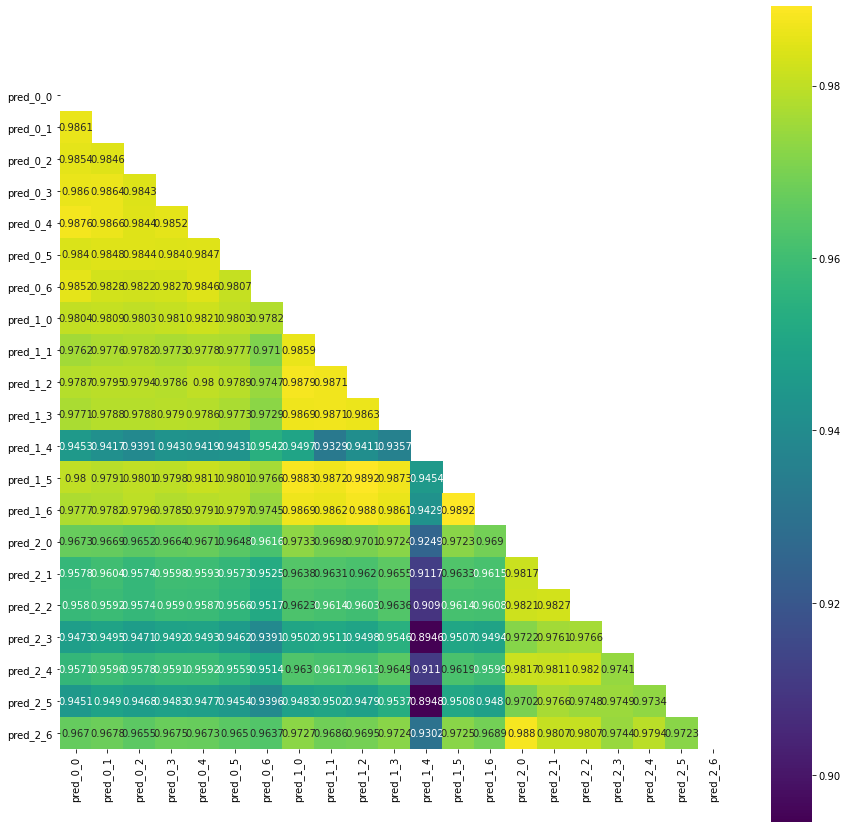

In [39]:
# Посмотрим корреляции предсказаний
corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Выполнить задание 2 для трех моделей.

In [40]:
# арифмитическое среднее
submission['sumbit_mean_3'] = scores.mean(axis=1)
# геометрического среднего
submission['sumbit_gmean_3'] = gmean(scores, axis=1)

In [43]:
# Выгрузим предсказания для Лидерборда
submission[['application_number', 'sumbit_mean_3']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_mean_3':'TARGET'}).\
            to_csv('out/sumbit_mean_3.csv', index = False)
submission[['application_number', 'sumbit_gmean_3']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_gmean_3':'TARGET'}).\
            to_csv('out/sumbit_gmean_3.csv', index = False)

Выводы: На лидерборде показатели такие:<br>
    арифмитическое среднее - 0.72349<br>
    геометрическое среднеее - 0.72375<br>
Показатели неплохо возрастают при использовании ансамбля моделей.

5.(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [51]:
# Объеденим ООФ прогнозы  в один датафрейм
scores_train = pd.DataFrame()
scores_train['xgb'] = oof_preds_xgb
scores_train['lgbm'] = oof_preds_lgbm
scores_train['cat'] = oof_preds_cat

In [53]:
# Обучим ЛогРегрессию на трейне
log = LogisticRegression()
log.fit(scores_train, target)

LogisticRegression()

In [64]:
# ПРименим логРегрессию к тестовым прогнозам, но сначало усредним прогнозы каждой модели
submission['xgb'] = scores[[col for col in scores.columns if col.startswith("pred_0")]].mean(axis=1)
submission['lgbm'] = scores[[col for col in scores.columns if col.startswith("pred_1")]].mean(axis=1)
submission['cat'] = scores[[col for col in scores.columns if col.startswith("pred_2")]].mean(axis=1)

In [69]:
# Получим прогнозы для теста
submission['sumbit_logreg'] = log.predict_proba(submission[['xgb', 'lgbm', 'cat']])[:, 1]
submission[['application_number', 'sumbit_logreg']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_logreg':'TARGET'}).\
            to_csv('out/sumbit_logreg.csv', index = False)